### Using ICA to reduce artefacts

This section will show how to use an independent component analysis (ICA) approach to suppress ocular and cardiac artefacts. This will be done by first performing an ICA decomposition of the data after which the components reflecting the artefacts are identified manually. As a last step the artefact components are 'projected out'.

### Import the necessary modules
Below are the required Python modules to be imported

In [1]:
import mne
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import array
from pprint import pprint
import json
import os.path as op
from mne_bids import (
    BIDSPath,
    make_dataset_description,
    print_dir_tree,
    read_raw_bids,
    write_meg_calibration,
    write_meg_crosstalk,
    write_raw_bids,
)
from mne_bids.stats import count_events
from mne.preprocessing import ICA

#### The filtered data is saved inside the derivative folder of the BIDS Directory. To import the data in this workspace the following steps will be followed.

#### File overview

The chapter relies on the file (embedded in the BIDS structure):

< BIDS_ROOT >/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif

and generates the output files:

< BIDS_ROOT >/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif


#### Specify your BIDS parameters along with the BIDS folder path

In [2]:
subject = '01'
session = '01'
task = 'SpAtt'
run = '01'
meg_suffix = 'meg'
hfc_suffix = 'raw_hfc'
ann_suffix = 'ann'
ica_suffix='ica'

data_path='/home/rakshita/rds_folders/Sproject3/OPM_data'
deriv_root = op.join(data_path, "Sub2_BIDS/derivatives/preprocessing")

bids_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix=hfc_suffix, 
            root=deriv_root, extension='.fif', check=False)

deriv_fname_fif = bids_path.basename.replace(hfc_suffix, ica_suffix) # fif output filename
deriv_fname_fif_1 = op.join(bids_path.directory, deriv_fname_fif)


print(bids_path)
print(deriv_fname_fif_1)


/home/rakshita/rds_folders/Sproject3/OPM_data/Sub2_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif
/home/rakshita/rds_folders/Sproject3/OPM_data/Sub2_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif



#### Resampling and filtering of the raw data

In order to do the ICA decomposition efficiently and keep all sub-data sets in memory, we will down-sample the data. We will use the dataset in which HFC was applied and annotations noted. Before resampling the data , a bandpass filter having bandwidth 3-30Hz will be applied. The 3 Hz highpass is important for removing slow drifts which otherwise would make the ICA decomposition less efficient.


In [ ]:
# Read the raw data from the BIDS path
raw = read_raw_bids(
    bids_path=bids_path, 
    extra_params={'preload': True}, 
    verbose=True
)

# Process the raw data
raw_resmpl = raw.copy().pick('meg')  # Keep only MEG channels
raw_resmpl.filter(3, 30)  # Band-pass filter from 3 to 30 Hz
raw_resmpl.resample(200)  # Downsample to 200 Hz


Opening raw data file /home/rakshita/rds_folders/Sproject3/OPM_data/Sub2_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif...


/tmp/ipykernel_18993/1612702471.py:2: RuntimeWarning: This filename (/home/rakshita/rds_folders/Sproject3/OPM_data/Sub2_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(


    Read a total of 8 projection items:
        HFC: l=1 m=-1 (1 x 67) active
        HFC: l=1 m=0 (1 x 67) active
        HFC: l=1 m=1 (1 x 67) active
        HFC: l=2 m=-2 (1 x 67) active
        HFC: l=2 m=-1 (1 x 67) active
        HFC: l=2 m=0 (1 x 67) active
        HFC: l=2 m=1 (1 x 67) active
        HFC: l=2 m=2 (1 x 67) active
    Range : 0 ... 1772379 =      0.000 ...  1772.379 secs
Ready.
Reading 0 ... 1772379  =      0.000 ...  1772.379 secs...



#### Applying the ICA algorithm

Now we apply the ICA algorithm. We have chosen for the fastica approach as it is well established and widely used. However, other ICA methods are available in MNE-Python. To expedite the computation, we have chosen to restric the ICA to the initial 30 components.


In [5]:
raw_resmpl_all = raw_resmpl
ica = ICA(method='fastica',
    random_state=96,
    n_components=30,
    verbose=True)

ica.fit(raw_resmpl_all,
    verbose=True)

Fitting ICA to data using 67 channels (please be patient, this may take a while)
    Applying projection operator with 8 vectors (pre-whitener computation)
    Applying projection operator with 8 vectors (pre-whitener application)
Selecting by number: 30 components
    Applying projection operator with 8 vectors (pre-whitener application)
Fitting ICA took 13.7s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,42 iterations on raw data (354476 samples)
ICA components,30
Available PCA components,67
Channel types,mag
ICA components marked for exclusion,—



#### Identifying the ICA components reflecting the artefacts

To plot the examples for the time-traces of the ICA components use:


In [6]:
%matplotlib inline
ica.plot_sources(raw_resmpl_all, title='ICA');

    Applying projection operator with 8 vectors (pre-whitener application)
Creating RawArray with float64 data, n_channels=30, n_times=354476
    Range : 0 ... 354475 =      0.000 ...  1772.375 secs
Ready.
Using qt as 2D backend.


Use the left/right arrow-keys to scroll through the data and the up/down arrow-keys to scroll through the components. Right-click on the IC names to see the corrisponding topographies and other details.

When inspecting the traces, it is clear that ICA001 reflects eye-blinks as measured most strongly and ICA000 reflects the ECG. This order of ICA components is specific to this data set and the seed (random_state) used for the ICA decomposition. For other data sets or using a different seed the components will come in a different order. Therefore the components associated with artefacts have to be identified manually.

#### To show the topographies of the each of the ICA components write:

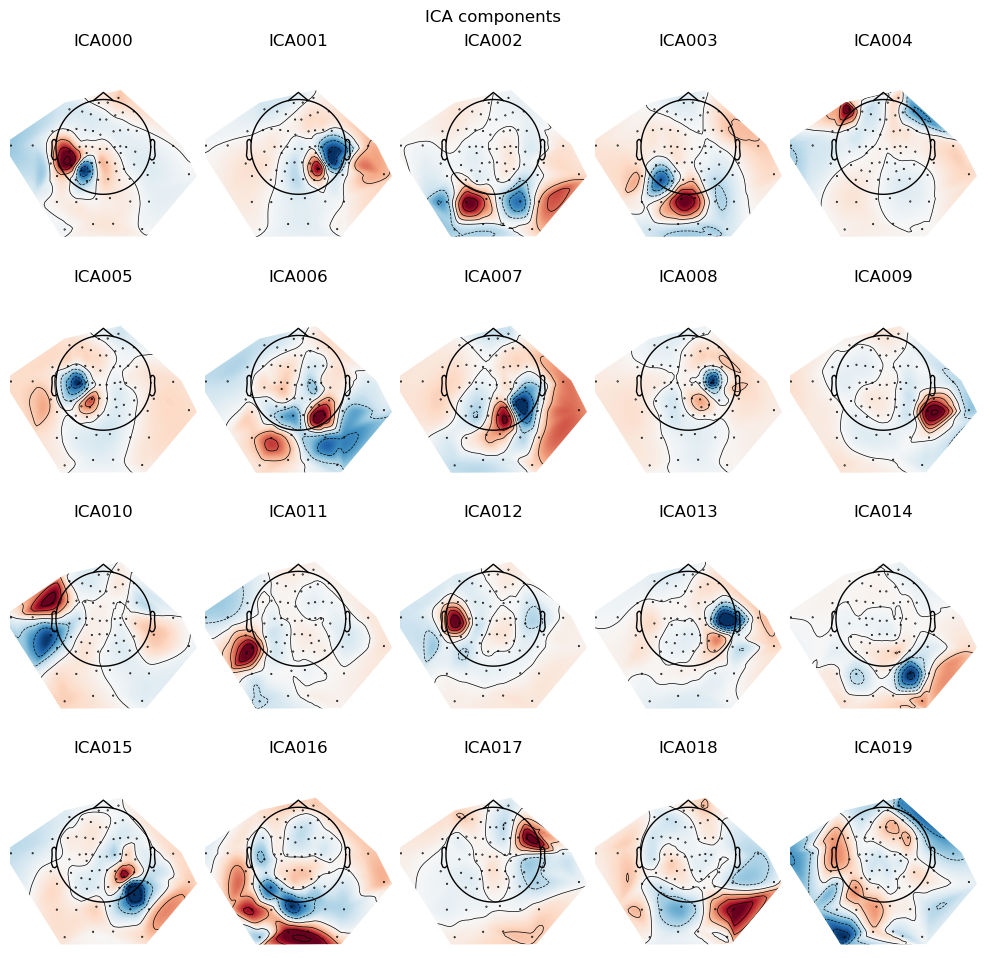

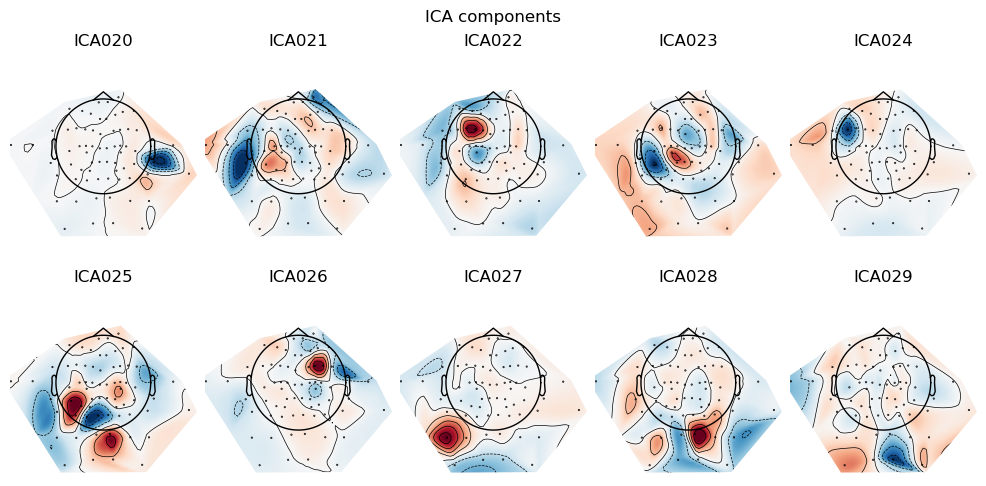

In [7]:
%matplotlib inline
ica.plot_components();

These plots show the topography associated with the OPM sensors. The topography of ICA004 look like a classical eye-blink artefacts with strong activity over frontal left and right sensors of opposite polarity. A typical ECG artefact can not be seen here as the homogeneus field correction applied on the data before removed the magnetic field arising from the heart.


How many components should in general be removed? As a rule of thumb not more than a handful. Typically only remove components which clearly reflect a physiological artefact. Removing too many components might remove brain activity as well.

### Attenuating the artefacts by applying the projections

Now that we have detected the ICA components associated with ocular and cardiac artefacts, we have to 'project out' them. This will be done by applying the ICA projections generated by ica.exclude to the original raw data which will be loaded again. After the ICA projections have been applied (ica.apply) the data will be saved.

In [ ]:
# Set the 4 components to exclude
ica.exclude = [4]


raw_ica = read_raw_bids(bids_path=bids_path,
                        extra_params={'preload':True},
                        verbose=True)
ica.apply(raw_ica)

raw_ica.save(deriv_fname_fif_1, overwrite=True)

Opening raw data file /home/rakshita/rds_folders/Sproject3/OPM_data/Sub2_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif...


/tmp/ipykernel_13351/649246201.py:5: RuntimeWarning: This filename (/home/rakshita/rds_folders/Sproject3/OPM_data/Sub2_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ica = read_raw_bids(bids_path=bids_path,


    Read a total of 8 projection items:
        HFC: l=1 m=-1 (1 x 67) active
        HFC: l=1 m=0 (1 x 67) active
        HFC: l=1 m=1 (1 x 67) active
        HFC: l=2 m=-2 (1 x 67) active
        HFC: l=2 m=-1 (1 x 67) active
        HFC: l=2 m=0 (1 x 67) active
        HFC: l=2 m=1 (1 x 67) active
        HFC: l=2 m=2 (1 x 67) active
    Range : 0 ... 1772379 =      0.000 ...  1772.379 secs
Ready.
Reading 0 ... 1772379  =      0.000 ...  1772.379 secs...



### Plotting the data to check the artefact reduction

We will here examine some of the traces to demonstrate the artefact reduction.


In [9]:
chs = ['L102_bz-s73', 'L211_bz-s46', 'R112_bz-s39', 'R211_bz-s34']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]

Then plot the data before the ICA projections were applied. Use the arrow button to scroll through the trials.

In [10]:
%matplotlib inline
raw.plot(order=chan_idxs, duration=5)

Channels marked as bad:
['L201_bz-s86', 'R106_bz-s3', 's16_bz']


The plot above shows the raw traces before the application of the ICA projections. Note the ocular artefacts in the OPM data at e.g. ~1 sec.

Then plot the same traces after the application of the ICA projections:

In [11]:
%matplotlib inline
raw_ica.plot(order=chan_idxs, duration=5)

NameError: name 'raw_ica' is not defined

As seen in the plot above, the ocular artefacts are clearly reduced.


### References

Hyvärinen A, Oja E. (2002) Independent component analysis: algorithms and applications. Neural Netw. 13(4-5):411-30. doi: 10.1016/s0893-6080(00)00026-5.

